https://www.kaggle.com/datasets/niharika41298/yoga-poses-dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import warnings
import tensorflow as tf
import os
import cv2
import pandas as pd
import imghdr
import imagehash
import random
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, save_img
from PIL import Image

warnings.filterwarnings("ignore")
%matplotlib inline

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

2023-12-07 14:25:24.579598: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-07 14:25:24.599282: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-07 14:25:24.599301: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-07 14:25:24.599834: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-07 14:25:24.603038: I tensorflow/core/platform/cpu_feature_guar

In [2]:
remove = ['../data/rescaled','../data/splits']
for dir in remove:
    if os.path.exists(dir):
        shutil.rmtree(dir)

data_dir = '../data/images'
image_exts = ['jpeg','jpg','bmp','png']

def remove_unsuable_images (data_dir):
    removed = 0
    hash_dict = {}
    
    for image_class in os.listdir(data_dir): 
        for image in os.listdir(os.path.join(data_dir, image_class)):
            image_path = os.path.join(data_dir, image_class, image)
            
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                os.remove(image_path)
                removed+=1
            with Image.open(image_path) as img:
                img_hash = imagehash.phash(img)
                if img_hash in hash_dict:
                    os.remove(image_path)
                    removed+=1
                else:
                    hash_dict[img_hash] = image_path

    print(f'removed {removed} unusable images')

remove_unsuable_images(data_dir)

removed 0 unusable images


In [3]:
images = tf.keras.utils.image_dataset_from_directory(data_dir)
data_iterator = images.as_numpy_iterator()
batch = data_iterator.next()

Found 1844 files belonging to 5 classes.


2023-12-07 14:25:43.128581: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-07 14:25:43.128693: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-07 14:25:43.128742: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

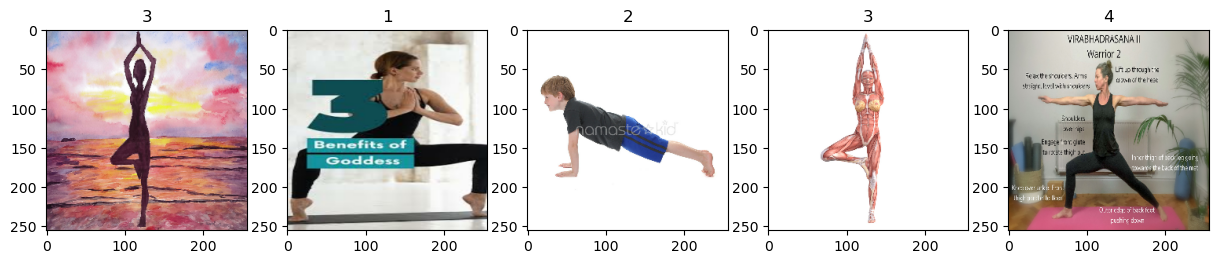

In [4]:
fig, ax = plt.subplots(ncols=5, figsize=(15,15))
for idx, img in enumerate(batch[0][:5]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [5]:
def resize_images(source, dest, target_size=(255, 255)):
    os.makedirs(dest, exist_ok=True)

    for dir in os.listdir(source):
        os.makedirs(os.path.join(dest, dir), exist_ok=True)
        source_sub = os.path.join(source, dir)
        dest_sub = os.path.join(dest, dir)
        print(source_sub, dest_sub)

        for file in os.listdir(source_sub):
            in_file = os.path.join(source_sub, file)
            out_file = os.path.join(dest_sub, file)

            with Image.open(in_file) as img:
                img_rgb = img.convert('RGB')
                resized = img_rgb.resize(target_size)
                resized.save(out_file)

resize_images(data_dir, '../data/rescaled')

../data/images/downdog ../data/rescaled/downdog
../data/images/goddess ../data/rescaled/goddess
../data/images/plank ../data/rescaled/plank
../data/images/tree ../data/rescaled/tree
../data/images/warrior2 ../data/rescaled/warrior2


In [6]:
def create_train_val_test_sets(root_dir, 
                               train_dir, 
                               val_dir, 
                               test_dir, 
                               holdout_size=10):
    
    for label in os.listdir(root_dir):
        label_path = os.path.join(root_dir, label)
        
        files = os.listdir(label_path)
        random.shuffle(files)
        test_images = files[:holdout_size]
        remaining_images = files[holdout_size:]
        val_images = remaining_images[:holdout_size]
        train_images = remaining_images[holdout_size:]

        for directory in [train_dir, val_dir, test_dir]:
            label_dest_path = os.path.join(directory, label)
            if not os.path.exists(label_dest_path):
                os.makedirs(label_dest_path)
                
        for img_name in val_images:
            src_path = os.path.join(label_path, img_name)
            dest_path = os.path.join(val_dir, label, img_name)
            shutil.move(src_path, dest_path)
            
        for img_name in test_images:
            src_path = os.path.join(label_path, img_name)
            dest_path = os.path.join(test_dir, label, img_name)
            shutil.move(src_path, dest_path)
            
        for img_name in train_images:
            src_path = os.path.join(label_path, img_name)
            dest_path = os.path.join(train_dir, label, img_name)
            shutil.move(src_path, dest_path)

root_dir = '../data/rescaled' 
train_dir = '../data/splits/train' 
val_dir = '../data/splits/validate' 
test_dir = '../data/splits/test'  

create_train_val_test_sets(root_dir, 
                           train_dir, 
                           val_dir, 
                           test_dir
                          )
shutil.rmtree('../data/rescaled')

Displaying images in: ../data/splits/test/warrior2


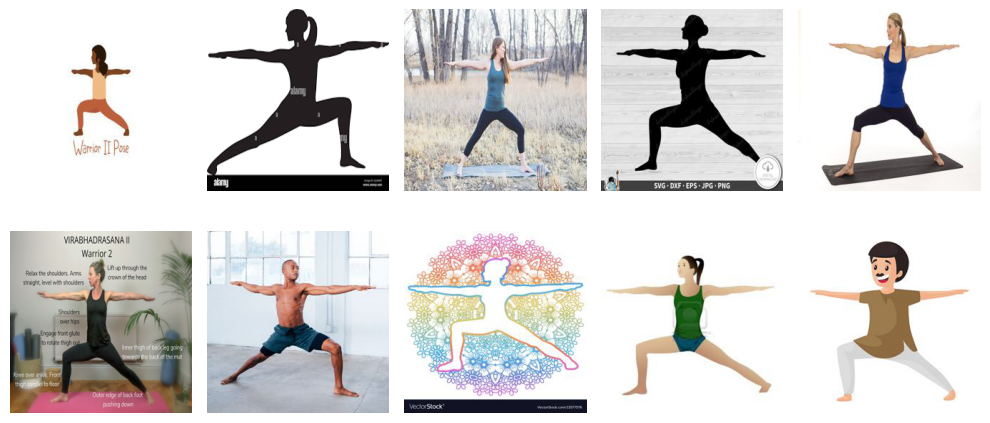

Displaying images in: ../data/splits/test/tree


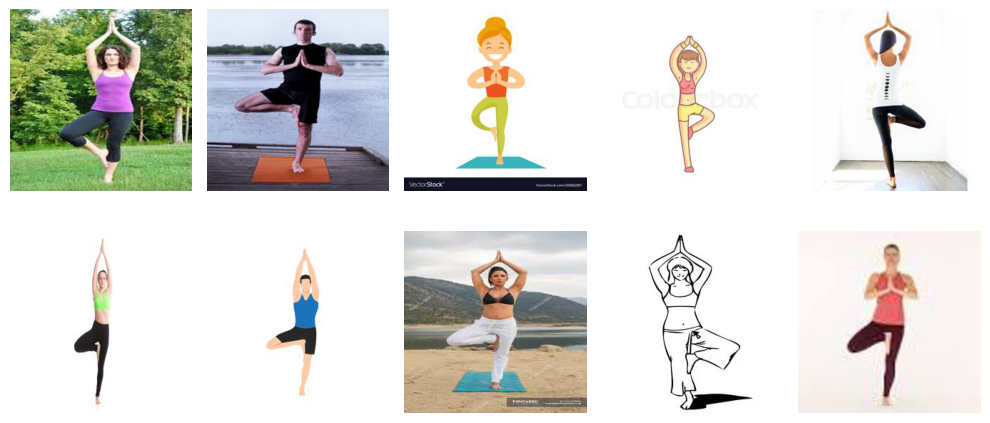

Displaying images in: ../data/splits/test/goddess


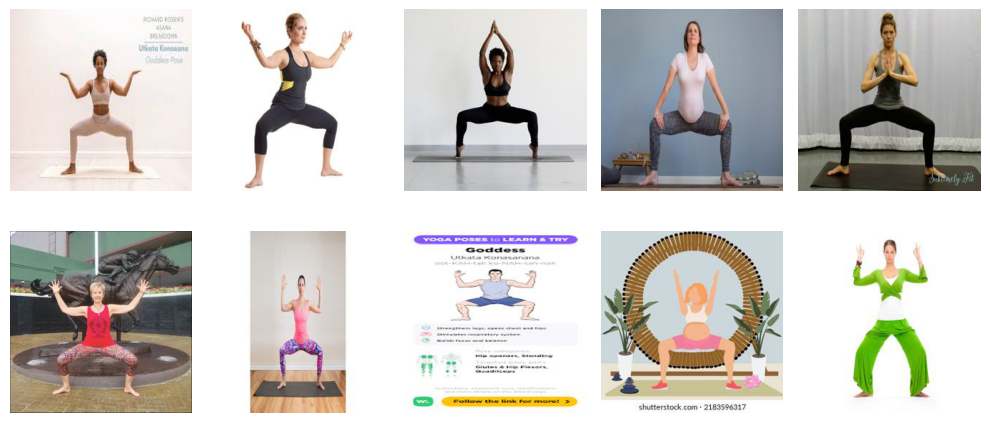

Displaying images in: ../data/splits/test/downdog


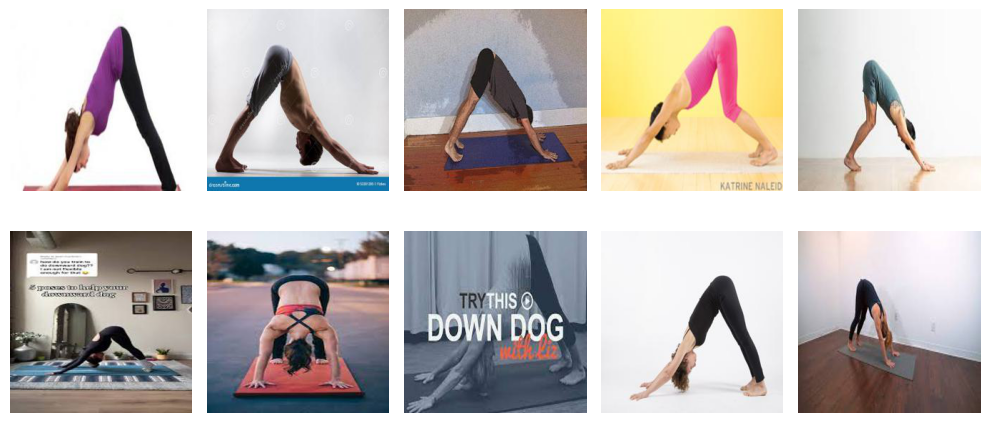

Displaying images in: ../data/splits/test/plank


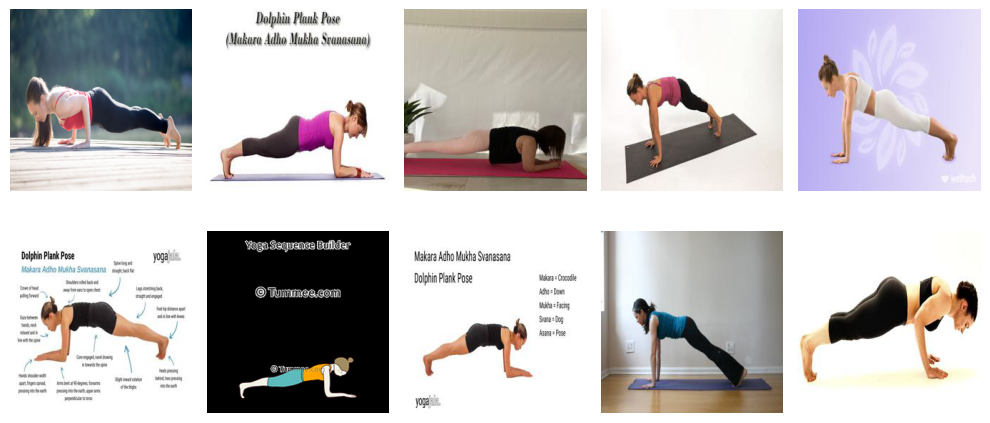

Displaying images in: ../data/splits/validate/tree


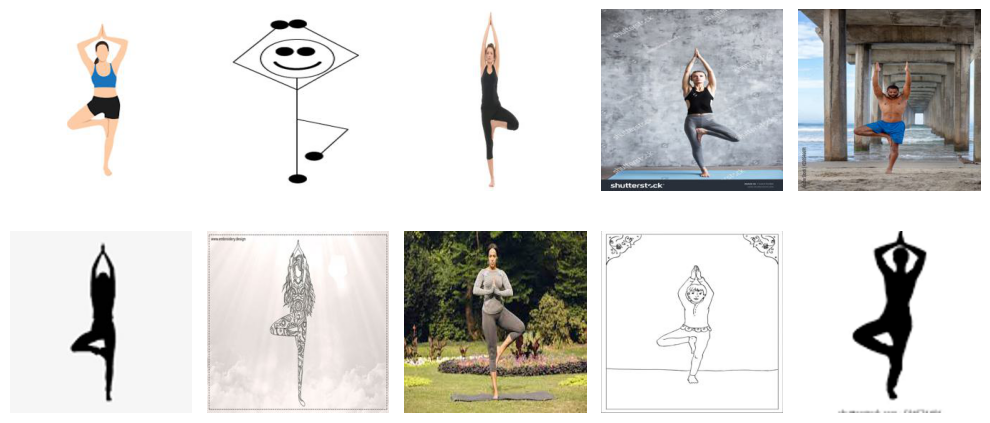

Displaying images in: ../data/splits/validate/plank


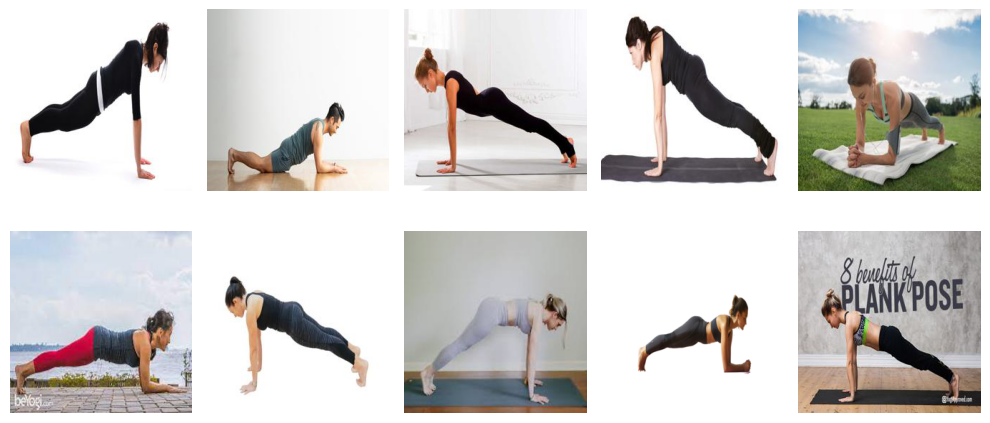

Displaying images in: ../data/splits/validate/warrior2


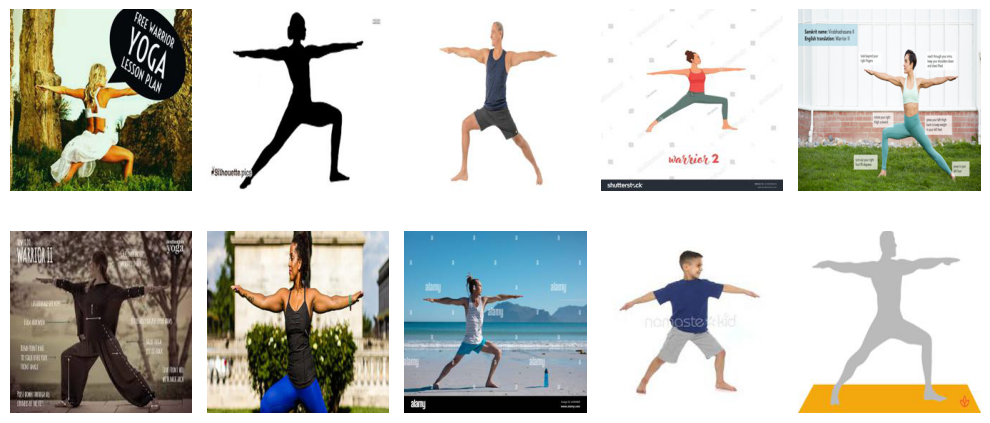

Displaying images in: ../data/splits/validate/goddess


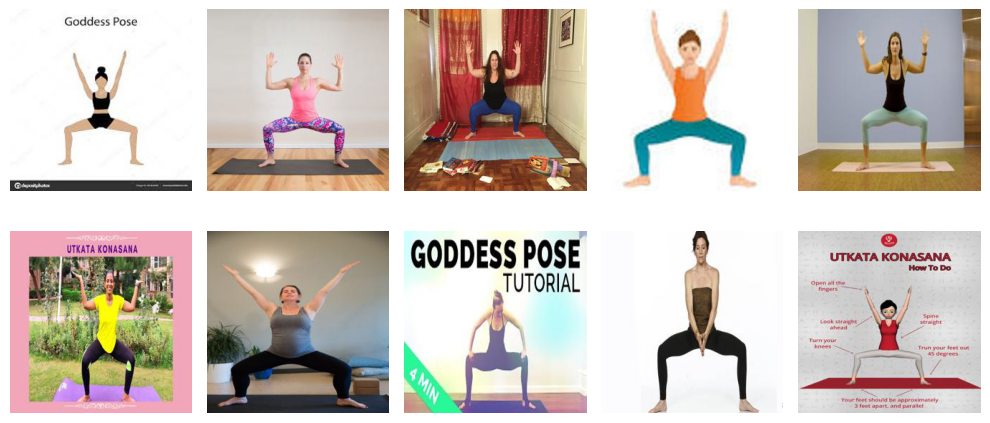

Displaying images in: ../data/splits/validate/downdog


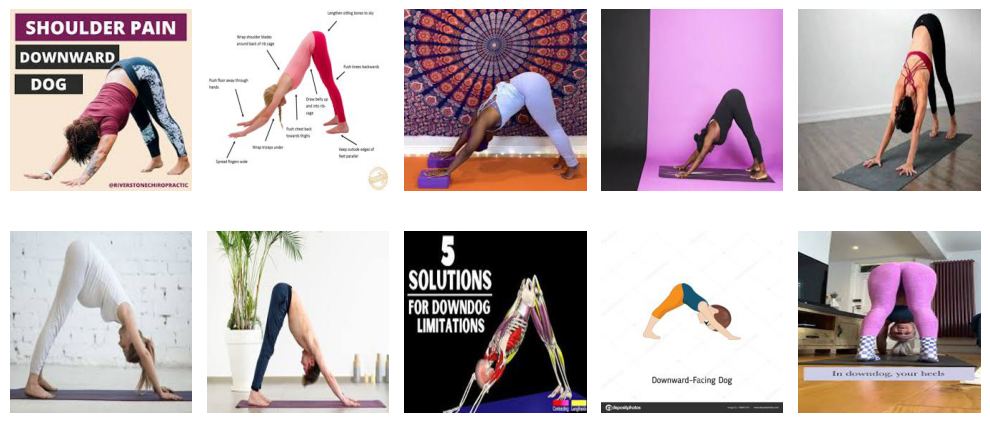

In [7]:
def display_images(image_dir, num_rows=2, num_cols=5):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 5))
    axes = axes.ravel()

    images = []
    image_files = os.listdir(image_dir)
    for i in range(min(len(image_files), num_rows * num_cols)):
        img_path = os.path.join(image_dir, image_files[i])
        img = mpimg.imread(img_path)
        images.append(img)

    for i, image in enumerate(images):
        axes[i].imshow(image)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

dirs = ['../data/splits/test', '../data/splits/validate']

for dir in dirs:
    for sub in os.listdir(dir):
        sub_path = os.path.join(dir, sub)
        if os.path.isdir(sub_path):
            print(f"Displaying images in: {sub_path}")
            display_images(sub_path)

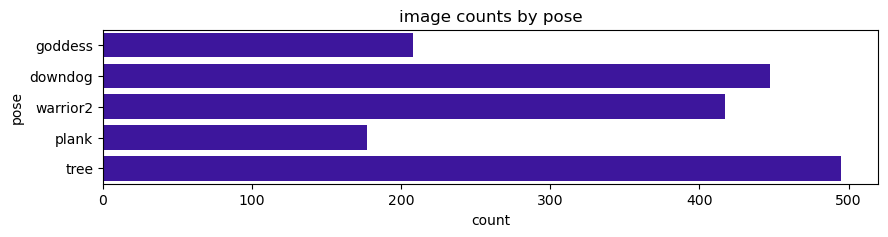

In [8]:
def class_count_hbar(root_dir):
    pose_counts = {}

    for root, dirs, files in os.walk(root_dir):
        if root == root_dir:
            continue
        folder_name = os.path.basename(root)  
        pose_counts[folder_name] = len(files)

    pose_counts = pd.DataFrame({'pose': list(pose_counts.keys()), 
                                'count': list(pose_counts.values())})
    plt.figure(figsize=(10, 2))
    sns.barplot(x='count', 
                y='pose', 
                data=pose_counts,
                color=(0.2, 0, 0.7)
               )

    plt.title('image counts by pose')
    plt.show()

class_count_hbar('../data/splits/train')

In [9]:
def augment_data(class_dir, target_count=1000):
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    current_count = len(os.listdir(class_dir))
    image_names = os.listdir(class_dir)

    while current_count < target_count:
        # Select a random image
        image_name = np.random.choice(image_names)
        image_path = os.path.join(class_dir, image_name)
        
        # Load and prepare the image
        img = load_img(image_path)
        img_array = img_to_array(img)
        img_array = img_array.reshape((1,) + img_array.shape)

        # Generate one batch (one transformed image) and save it
        batch = datagen.flow(img_array, batch_size=1, save_to_dir=class_dir, save_prefix='aug', save_format='jpeg')
        batch.next()
        current_count += 1

data_dir = '../data/splits/train'  # Replace with your actual data directory
for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    augment_data(class_dir)

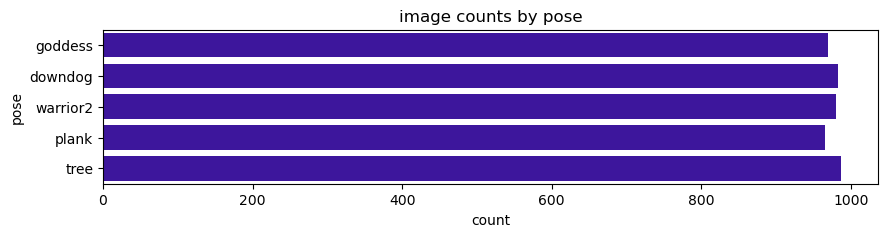

In [10]:
class_count_hbar('../data/splits/train')

In [11]:
import os

def display_folder_structure_and_count(root_dir):
    for root, dirs, files in os.walk(root_dir):
        level = root.replace(root_dir, '').count(os.sep)
        indent = ' ' * 4 * level
        print(f"{indent}{os.path.basename(root)}/ ({len(files)} files)")

root_directory = '../data'
display_folder_structure_and_count(root_directory)


data/ (0 files)
    images/ (0 files)
        downdog/ (467 files)
        goddess/ (228 files)
        plank/ (197 files)
        tree/ (515 files)
        warrior2/ (437 files)
    splits/ (0 files)
        test/ (0 files)
            warrior2/ (10 files)
            tree/ (10 files)
            goddess/ (10 files)
            downdog/ (10 files)
            plank/ (10 files)
        validate/ (0 files)
            tree/ (10 files)
            plank/ (10 files)
            warrior2/ (10 files)
            goddess/ (10 files)
            downdog/ (10 files)
        train/ (0 files)
            goddess/ (970 files)
            downdog/ (983 files)
            warrior2/ (980 files)
            plank/ (966 files)
            tree/ (987 files)
